# Bigwarp .zarr to OME TIFF

This notebook provides example code snippets for reading (Bigwarp) .zarrs and writing pyramidal OME TIFFs.

## Setting up a conda environment

```bash
conda env create -f environment.yml
conda activate zarr-ometiff
```

## Data

In [17]:
# TODO: make bigwarp zarr available
# TODO: make source images used by bigwarp available
# TODO: make bigwarp landmarks available
# TODO: describe bigwarp registration process and output settings

## Bigwarp .zarr layout on disk

In [6]:
!dir D:\Frank\BigWarp-Troubleshooting-MarineLab\bigwarp.zarr

 Volume in drive D is Frank T7
 Volume Serial Number is 04B4-9A7C

 Directory of D:\Frank\BigWarp-Troubleshooting-MarineLab\bigwarp.zarr

06/02/2024  16:02    <DIR>          .
06/02/2024  16:02    <DIR>          ..
06/02/2024  16:02    <DIR>          warped
06/02/2024  16:28                17 .zgroup
               1 File(s)             17 bytes
               3 Dir(s)  661.623.406.592 bytes free


In [7]:
!dir D:\Frank\BigWarp-Troubleshooting-MarineLab\bigwarp.zarr\warped

 Volume in drive D is Frank T7
 Volume Serial Number is 04B4-9A7C

 Directory of D:\Frank\BigWarp-Troubleshooting-MarineLab\bigwarp.zarr\warped

06/02/2024  16:02    <DIR>          .
06/02/2024  16:02    <DIR>          ..
06/02/2024  16:28                17 .zgroup
06/02/2024  16:02    <DIR>          cycle2-s0-DAPI
06/02/2024  16:07    <DIR>          cycle2-s0-Opal_570
06/02/2024  16:12    <DIR>          cycle2-s0-Opal_690
06/02/2024  16:17    <DIR>          cycle2-s0-Opal_780
06/02/2024  16:23    <DIR>          cycle2-s0-Opal_520
06/02/2024  16:28    <DIR>          cycle2-s0-Sample_AF
               1 File(s)             17 bytes
               8 Dir(s)  661.623.406.592 bytes free


In [11]:
!dir D:\Frank\BigWarp-Troubleshooting-MarineLab\bigwarp.zarr\warped\cycle2-s0-DAPI\.z*

 Volume in drive D is Frank T7
 Volume Serial Number is 04B4-9A7C

 Directory of D:\Frank\BigWarp-Troubleshooting-MarineLab\bigwarp.zarr\warped\cycle2-s0-DAPI

06/02/2024  16:07               154 .zarray
06/02/2024  16:07               136 .zattrs
               2 File(s)            290 bytes
               0 Dir(s)  661.623.406.592 bytes free


In [13]:
# Additionally this folder contains many <number>.<number> image chunks.

## Open Bigwarp .zarr

In [14]:
import os
import zarr
from pathlib import Path
from typing import Tuple

In [18]:
zarr_path = r'D:\Frank\BigWarp-Troubleshooting-MarineLab\bigwarp.zarr'
assert Path.exists(Path(zarr_path))

In [19]:
root = zarr.open(zarr_path, 'r')

In [20]:
root.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='warped', nodes=(Node(disabled=True,…

In [21]:
# Get the name of the first group in the zarr
# (in the case of bigwarp zarr there is only one)
group_key = list(root)[0]
group = root[group_key]
group

<zarr.hierarchy.Group '/warped' read-only>

In [22]:
channel_group_names = [item[1].name for item in group.items()]
channel_group_names

['/warped/cycle2-s0-DAPI',
 '/warped/cycle2-s0-Opal_520',
 '/warped/cycle2-s0-Opal_570',
 '/warped/cycle2-s0-Opal_690',
 '/warped/cycle2-s0-Opal_780',
 '/warped/cycle2-s0-Sample_AF']

In [23]:
def _zarr_image_get_pixelsize_um(root, group_name) -> Tuple[float, float]:
    # As an example a transform attribute for an image channel in a Bigwarp zarr:
    # {'axes': ['y', 'x'], 'scale': [0.0002495152876362007, 0.0002495152876362007, 0.001], 'translate': [0.0, 0.0, 0.0], 'units': ['mm', 'mm']}
    # It is inconsistent because sometimes it specifies three dimensions, and sometimes two.
    transform = root[group_name].attrs['transform']
    print(f'Image transform {transform}')

    assert transform['axes'] == ['y', 'x']
    assert transform['translate'] == [0.0, 0.0, 0.0]
    assert transform['units'] == ['mm', 'mm']

    scale = transform['scale']
    assert len(scale) == 3  # the 3rd dimensions is probably a default z-plane distance of 1 micron

    pixel_size_y_um = scale[0] * 1000.0 
    pixel_size_x_um = scale[1] * 1000.0

    return (pixel_size_y_um, pixel_size_x_um)

## Visual exploration of the zarr

In [24]:
import matplotlib.pyplot as plt

In [25]:
# Read the first channel as an example
img = root[channel_group_names[0]]
img

<zarr.core.Array '/warped/cycle2-s0-DAPI' (63360, 69120) uint8 read-only>

In [26]:
# The physical pixel size can be recovered from the zarr attributes dictionary
# associated with the zarr group holding the (single channel) image.
img.attrs['transform']

{'axes': ['y', 'x'],
 'scale': [0.0002495152876362007, 0.0002495152876362007, 0.001],
 'translate': [0.0, 0.0, 0.0],
 'units': ['mm', 'mm']}

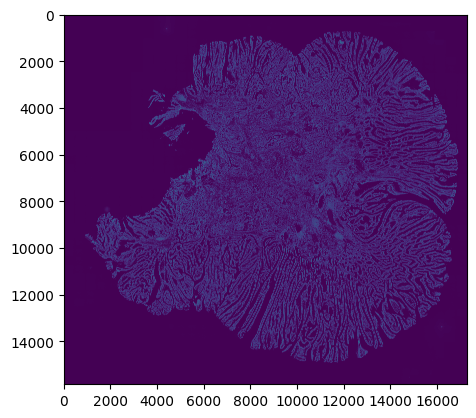

In [27]:
plt.imshow(img[::4,::4])

## Pyramidal OME TIFF Writing

In [28]:
from skimage.transform import downscale_local_mean
from typing import List, Optional, Tuple, Iterator
import numpy as np
import tifffile
import math
import dask.array as da

In [29]:
def write_pyramidal_ome_tiff(img_stack: da.Array,                # dask array image stack of shape (channels, y, x)
                             pyramid_filename: str,
                             channel_names: Optional[List[str]],
                             pixel_size_um: Optional[Tuple[float, float]],        # pixel size in microns, or None
                             compression: Optional[str],         # 'zlib' or None
                             tile_size: int,                     # tile size (in pixels) in output OME TIFF file
                             max_levels: int,
                             downsample_method: str) -> None:    # downsample method = 'box' (better quality, slower) or 'nearest neighbor' (faster, poorer quality)

    num_pyramid_levels: int = max_levels  # CHECKME: do we need to clip this value in case we would end up with <= 1 pixel images in the pyramid?

    ome_metadata = _make_ome_metadata(img_stack, channel_names, pixel_size_um)

    tile_sizes = (tile_size, tile_size)

    options = dict(tile=tile_sizes,
                   photometric='minisblack',
                   compression=compression,
                   metadata=ome_metadata,
                   software=_creator())
    
    num_channels, image_height, image_width = img_stack.shape

    # Create output folder if it does not exist yet.
    Path(pyramid_filename).parent.mkdir(parents=True, exist_ok=True)

    print(f'Writing pyramidal OME TIFF file {pyramid_filename} (compression: {options["compression"]})')
    with tifffile.TiffWriter(pyramid_filename, ome=True, bigtiff=True) as tif:
        
        # Write full resolution image
        print(f'Writing level 0: {image_width} x {image_height} px')
        downsample_factor = 1
        tif.write(data=_tiles_generator(img_stack, tile_sizes, downsample_factor, downsample_method),
                  shape=(num_channels, image_height, image_width, 1),
                  dtype=img_stack.dtype,
                  subifds=num_pyramid_levels-1,
                  **options)

        # Save downsampled pyramid images to the subifds
        for level in range(1, num_pyramid_levels):
            downsampled_data_shape = math.ceil(image_height / (2**level)), math.ceil(image_width / (2**level))
            print(f'Writing level {level}: {downsampled_data_shape[1]} x {downsampled_data_shape[0]} px')
            downsample_factor = 2**level
            tif.write(data=_tiles_generator(img_stack, tile_sizes, downsample_factor, downsample_method), 
                      shape=(num_channels, downsampled_data_shape[0], downsampled_data_shape[1], 1),
                      dtype=img_stack.dtype,
                      subfiletype=1,
                      **options)


def _tiles_generator(img_stack: da.Array,
                     tile_sizes: Tuple[int, int],
                     downsample_factor: int,
                     downsample_method: str) -> Iterator[np.ndarray]:
    # See also https://forum.image.sc/t/tifffile-ome-tiff-generation-is-taking-too-much-ram/41865/16
    # and https://github.com/labsyspharm/ashlar/blob/5bf5b8710f456e68e33ff232708cda0b1c904a33/ashlar/reg.py
    tile_height, tile_width = tile_sizes
    num_channels = img_stack.shape[0]
    for c in range(num_channels):
        print(f'  channel {c+1}/{num_channels}')

        # Get a full numpy array image from the dask array.
        # This loses dask chunk advantages (limited peak memory consumption), but avoids tiling artefacts in our naive downsampling implementation.
        # It also makes our retiling (from dask chunk size to OME TIFF tile size) trivial.
        # IMPROVEME: for downsampling of the original dask arrays we may get some inspiration here:
        # https://github.com/spatial-image/multiscale-spatial-image/blob/0c6f65cdc69cb069e81cdc07e7f3f5441f0cc4e5/multiscale_spatial_image/to_multiscale/_dask_image.py#L100
        # However, we may still need to retile afterwards.
        image = img_stack[c].compute()  

        # Downsample
        image = _downsample_image(image, downsample_factor, downsample_method)

        # Generate tiles
        image_height, image_width = image.shape
        for y in range(0, image_height, tile_height):
            for x in range(0, image_width, tile_width):
                yield image[y:y+tile_height, x:x+tile_width].copy()


def _downsample_image(img: np.ndarray,
                      downsample_factor: int,
                      downsample_method: str) -> np.ndarray:

    if downsample_factor != 1:
        if downsample_method == 'box':
            # Box filter. This yields dramatically better quality than nearest neighbor but is slower.
            img = downscale_local_mean(img, (downsample_factor, downsample_factor)).astype(img.dtype)
        else:
            # Nearest neighbor downsampling. Fast but poor quality.
            img = img[::downsample_factor, ::downsample_factor]

    return img


def _make_ome_metadata(img_stack: da.Array,
                       channel_names: Optional[List[str]],
                       pixel_size_um: Optional[Tuple[float, float]]):

    # Collect OME metadata
    ome_metadata = {}
    ome_metadata['Creator'] = _creator()
    if pixel_size_um:
        pixel_size_y_um, pixel_size_x_um = pixel_size_um
        print(f'Pixel size: {pixel_size_um} micrometer')
        ome_metadata['PhysicalSizeX'] = str(pixel_size_x_um)
        ome_metadata['PhysicalSizeXUnit'] = 'µm'
        ome_metadata['PhysicalSizeY'] = str(pixel_size_y_um)
        ome_metadata['PhysicalSizeYUnit'] = 'µm'

    if channel_names:
        print(f'Channel names: {channel_names}')
        assert len(channel_names) == img_stack.shape[0]
        ome_metadata['Channel'] = {'Name': channel_names}

    return ome_metadata    


def _creator() -> str:
    return f'zarr-ometiff'


## Save zarr as single channel OME TIFFs

In [30]:
tile_size: int = 1024
max_levels: int = 6         # number of image pyramid levels
downsample_method = 'box'
compression = 'zlib'

In [31]:
# *Optionally* we can define a dictionary to map image names as used in Bigwarp's zarr
# to filenames that we want the exported OME TIFFs to have.

# orig_filenames = {
#  'cycle2-s0-DAPI' : 'some_other_filename_DAPI',
#  'cycle2-s0-Opal_520' : 'some_other_filename_Opal_520',
#  'cycle2-s0-Opal_570' : 'some_other_filename_Opal_570',
#  'cycle2-s0-Opal_690' : 'some_other_filename_Opal_690',
#  'cycle2-s0-Opal_780' : 'some_other_filename_Opal_780',
#  'cycle2-s0-Sample_AF' : 'some_other_filename_Sample_AF'
# }

In [32]:
from typing import Dict, Optional

def group_name_to_channel_name(group_name: str, renaming_dict: Optional[Dict[str, str]]=None) -> str:
   # A group name look like this: '/warped/cycle2-s0-Opal_520'
    # we extract the channel name as the part after the second'/'.
    channel_name = group_name.split('/')[2]

    # Optionally rename channel
    if renaming_dict:
        channel_name = renaming_dict[channel_name]

    return channel_name

Write each channel separately to a single-channel pyramidal OME TIFF.

In [33]:
output_folder = r'D:\Frank\BigWarp-Troubleshooting-MarineLab\registered'

In [34]:
for channel, channel_group_name in enumerate(channel_group_names):
    renaming_dict = None  # we would use orig_filenames here, if needed
    channel_name = group_name_to_channel_name(channel_group_name, renaming_dict)

    print(f'Channel {channel}: {channel_group_name} -> {channel_name}')

    pyramid_filename = os.path.join(output_folder, f'{channel_name}.tif')

    img_channel = da.expand_dims(da.array(root[channel_group_name]), axis=0)

    pixel_size_um: Tuple[float, float] = _zarr_image_get_pixelsize_um(root, f'{channel_group_name}')

    write_pyramidal_ome_tiff(img_channel,
                             pyramid_filename,
                             [channel_name],
                             pixel_size_um,
                             compression,
                             tile_size,
                             max_levels,
                             downsample_method)

Channel 0: /warped/cycle2-s0-DAPI -> cycle2-s0-DAPI
Image transform {'axes': ['y', 'x'], 'scale': [0.0002495152876362007, 0.0002495152876362007, 0.001], 'translate': [0.0, 0.0, 0.0], 'units': ['mm', 'mm']}
Pixel size: (0.24951528763620068, 0.24951528763620068) micrometer
Channel names: ['cycle2-s0-DAPI']
Writing pyramidal OME TIFF file D:\Frank\BigWarp-Troubleshooting-MarineLab\registered\cycle2-s0-DAPI.tif (compression: zlib)
Writing level 0: 69120 x 63360 px
  channel 1/1
Writing level 1: 34560 x 31680 px
  channel 1/1
Writing level 2: 17280 x 15840 px
  channel 1/1
Writing level 3: 8640 x 7920 px
  channel 1/1
Writing level 4: 4320 x 3960 px
  channel 1/1
Writing level 5: 2160 x 1980 px
  channel 1/1
Channel 1: /warped/cycle2-s0-Opal_520 -> cycle2-s0-Opal_520
Image transform {'axes': ['y', 'x'], 'scale': [0.0002495152876362007, 0.0002495152876362007, 0.001], 'translate': [0.0, 0.0, 0.0], 'units': ['mm', 'mm']}
Pixel size: (0.24951528763620068, 0.24951528763620068) micrometer
Channel

## Example code for saving multi-channel OME TIFFs

In a realistic Bigwarp registration setting one typically has two multi-channel images, for example two .qptiff files. The DAPI channel from one .qptiff, and all channels (also including a DAPI channel) from the other .qptiff are fed to Bigwarp for registration. Bigwarp is then used to output the warped channels from the second .qptiff, as a .zarr file.

We might then want to combine all channels from the first .qptiff with all warped channels of the second .qptiff.

We could do so by reading the first .qptiff into a 3D dask array, also read the zarr with warped channels into a 3D dask array, stack these arrays to a new 3D array, and then export them to a single new multi-channel OME TIFF file.

We don't have the complete code for this here, yet (TODO!), but we provide an example for the second half of the task: reading the .zarr into a 3D dask array and exporting that to a multi-channel OME TIFF.

In [38]:
das = [da.array(root[channel_group_name])
       for channel_group_name
       in channel_group_names]
das

[dask.array<array, shape=(63360, 69120), dtype=uint8, chunksize=(10240, 10240), chunktype=numpy.ndarray>,
 dask.array<array, shape=(63360, 69120), dtype=uint8, chunksize=(10240, 10240), chunktype=numpy.ndarray>,
 dask.array<array, shape=(63360, 69120), dtype=uint8, chunksize=(10240, 10240), chunktype=numpy.ndarray>,
 dask.array<array, shape=(63360, 69120), dtype=uint8, chunksize=(10240, 10240), chunktype=numpy.ndarray>,
 dask.array<array, shape=(63360, 69120), dtype=uint8, chunksize=(10240, 10240), chunktype=numpy.ndarray>,
 dask.array<array, shape=(63360, 69120), dtype=uint8, chunksize=(10240, 10240), chunktype=numpy.ndarray>]

In [39]:
# Merge 2D daskarrays to a single 3D array
img_stack = da.stack(das)  # shape is (channels, y, x)
img_stack

dask.array<stack, shape=(6, 63360, 69120), dtype=uint8, chunksize=(1, 10240, 10240), chunktype=numpy.ndarray>

In [40]:
print(type(img_stack))
print(img_stack.dtype)
print(img_stack.shape)

<class 'dask.array.core.Array'>
uint8
(6, 63360, 69120)


In [41]:
renaming_dict = None  # we would use orig_filenames here, if needed
channel_names = [group_name_to_channel_name(channel_group_name, renaming_dict) for channel_group_name in channel_group_names]
channel_names

['cycle2-s0-DAPI',
 'cycle2-s0-Opal_520',
 'cycle2-s0-Opal_570',
 'cycle2-s0-Opal_690',
 'cycle2-s0-Opal_780',
 'cycle2-s0-Sample_AF']

In [ ]:
combined_channels_filename = r'D:\Frank\BigWarp-Troubleshooting-MarineLab\registered-combined.ome.tif'

write_pyramidal_ome_tiff(img_stack,
                         combined_channels_filename,
                         channel_names,
                         pixel_size_um,
                         compression,
                         tile_size,
                         max_levels,
                         downsample_method)